## EfficientNetB0
### Database: [Plant Diseases Training Dataset](https://www.kaggle.com/datasets/nirmalsankalana/plant-diseases-training-dataset/data)

#### Testing on modified images

In [1]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras
from keras import layers

import sys
sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/modified/train/'

In [2]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [3]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 76486 files belonging to 38 classes.
Using 61189 files for training.
Using 15297 files for validation.


2024-02-18 11:32:08.691695: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-18 11:32:08.691724: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-18 11:32:08.691736: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-18 11:32:08.691895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 11:32:08.692166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#check an example 
val_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

In [5]:
import tensorflow.keras.backend as K
K.clear_session()

In [6]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [42]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [43]:
model = build_model(num_classes=38)

epochs = 2  # @param {type: "slider", min:8, max:80}
hist_basic = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

plot_hist(hist_basic)

Epoch 1/2
1913/1913 [==============================] - 537s 276ms/step - loss: 1.2170 - accuracy: 0.6966 - val_loss: 0.8167 - val_accuracy: 0.7558
Epoch 2/2
1913/1913 [==============================] - 522s 272ms/step - loss: 0.9134 - accuracy: 0.7278 - val_loss: 0.7894 - val_accuracy: 0.7605


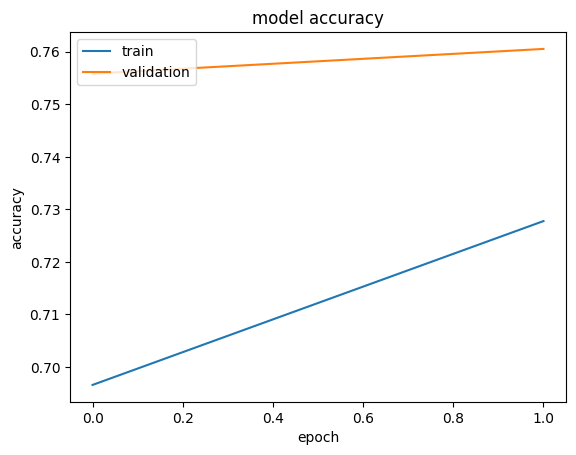

In [44]:
plot_hist(hist_basic)

In [7]:

IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [8]:
model = build_model(num_classes=38)

epochs = 2

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [10]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model

Epoch 1/12
1913/1913 [==============================] - 563s 294ms/step - loss: 2.3780 - accuracy: 0.4381 - val_loss: 1.4888 - val_accuracy: 0.6252
Epoch 2/12
1913/1913 [==============================] - 594s 310ms/step - loss: 1.4320 - accuracy: 0.6270 - val_loss: 1.1138 - val_accuracy: 0.7008
Epoch 3/12
1913/1913 [==============================] - 557s 291ms/step - loss: 1.1492 - accuracy: 0.6835 - val_loss: 0.9357 - val_accuracy: 0.7343
Epoch 4/12
1913/1913 [==============================] - 608s 318ms/step - loss: 0.9949 - accuracy: 0.7163 - val_loss: 0.8288 - val_accuracy: 0.7579
Epoch 5/12
1913/1913 [==============================] - 603s 315ms/step - loss: 0.8938 - accuracy: 0.7387 - val_loss: 0.7624 - val_accuracy: 0.7721
Epoch 6/12
1913/1913 [==============================] - 618s 323ms/step - loss: 0.8208 - accuracy: 0.7559 - val_loss: 0.7097 - val_accuracy: 0.7841
Epoch 7/12
1913/1913 [==============================] - 678s 354ms/step - loss: 0.7654 - accuracy: 0.7685 - val_

/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


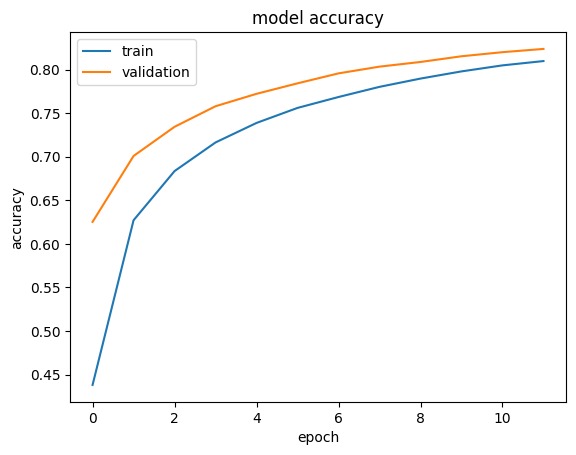

In [51]:
# Create a new model with unfrozen layers
unfrozen_model = unfreeze_model_and_clone(model)

epochs = 2
hist = unfrozen_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the model to disk
#unfrozen_model.save("unfrozen_model.h5")

#plot_hist(hist)

Epoch 1/10
1913/1913 [==============================] - 617s 316ms/step - loss: 2.4476 - accuracy: 0.4255 - val_loss: 1.4971 - val_accuracy: 0.6212
Epoch 2/10
1913/1913 [==============================] - 615s 321ms/step - loss: 1.4341 - accuracy: 0.6238 - val_loss: 1.1183 - val_accuracy: 0.6965
Epoch 3/10
1913/1913 [==============================] - 652s 340ms/step - loss: 1.1499 - accuracy: 0.6816 - val_loss: 0.9410 - val_accuracy: 0.7339
Epoch 4/10
1913/1913 [==============================] - 707s 369ms/step - loss: 0.9974 - accuracy: 0.7154 - val_loss: 0.8343 - val_accuracy: 0.7554
Epoch 5/10
1913/1913 [==============================] - 669s 349ms/step - loss: 0.8958 - accuracy: 0.7370 - val_loss: 0.7639 - val_accuracy: 0.7745
Epoch 6/10
1913/1913 [==============================] - 681s 356ms/step - loss: 0.8264 - accuracy: 0.7545 - val_loss: 0.7132 - val_accuracy: 0.7871
Epoch 7/10
1913/1913 [==============================] - 749s 391ms/step - loss: 0.7692 - accuracy: 0.7686 - val_

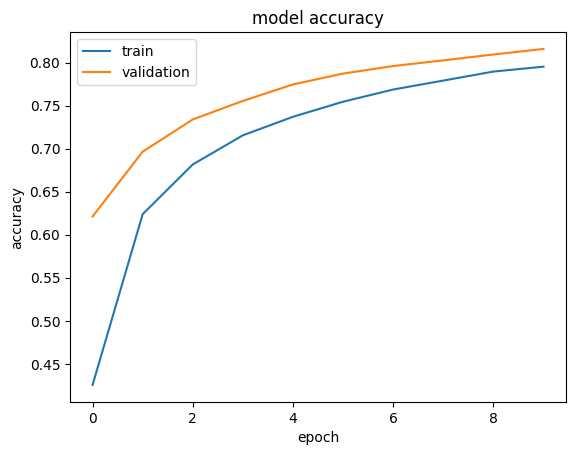

In [58]:
# Create a new model with unfrozen layers
unfrozen_model_mod_2 = unfreeze_model_and_clone(model)

epochs = 10
hist_mod_2 = unfrozen_model_mod_2.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the model to disk
#unfrozen_model.save("unfrozen_model_mod.h5")

plot_hist(hist_mod_2)

In [69]:
# Save the trained model to the specified directory
model_dir = "../models/"
model_filename = "unfrozen_model_mod_2.h5"
unfrozen_model_mod_2.save(os.path.join(model_dir, model_filename))

# You can load it back with keras.models.load_model().

/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


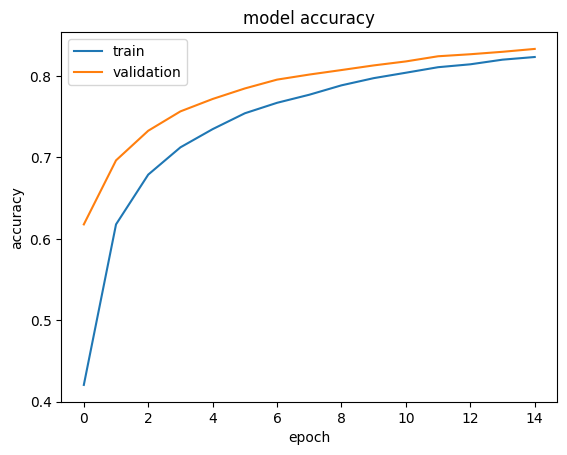

In [13]:
#Once more with more epochs

K.clear_session()

# Create a new model with unfrozen layers
unfrozen_model_mod_3 = unfreeze_model_and_clone(model)

epochs = 15
hist_3 = unfrozen_model_mod_3.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the model to disk
unfrozen_model_mod_3.save("unfrozen_model_mod_3.h5")

plot_hist(hist_3)

------------------------------------------------------------------------------------------------------------------------------------------
#### Testing of the model with unseen data
------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

In [15]:
dataset_test_path = '../data/modified/test/'

test_ds = load_test(dataset_test_path)

Found 19238 files belonging to 38 classes.


In [16]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 38), dtype=tf.float32, name=None))>

In [17]:
# Make predictions on the test dataset
predictions = unfrozen_model_mod_3.predict(test_ds)

602/602 [==============================] - 181s 294ms/step


------------------------------------------------------------------------------------------------------------------------------------------
#### Plotting the results and getting evaluation metrics
------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = unfrozen_model_mod_3.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)


602/602 [==============================] - 165s 273ms/step


NameError: name 'classification_report' is not defined

In [21]:
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.93      0.72      0.81       128
    bacterial_blight       0.68      0.48      0.57       584
      bacterial_spot       0.93      0.96      0.94      1157
      bacterial_wilt       0.72      0.60      0.65       113
       black_measles       0.90      0.78      0.83       449
           black_rot       0.98      0.96      0.97       384
               blast       0.79      0.74      0.77       303
          brown_spot       0.85      0.83      0.84       341
brown_streak_disease       0.50      0.39      0.44       451
     citrus_greening       1.00      1.00      1.00      1183
         common_rust       0.94      0.90      0.92       224
        early_blight       0.93      0.84      0.88       656
      gray_leaf_spot       0.72      0.51      0.60        98
           gray_spot       0.71      0.70      0.70        76
        green_mottle       0.35      0.10     

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


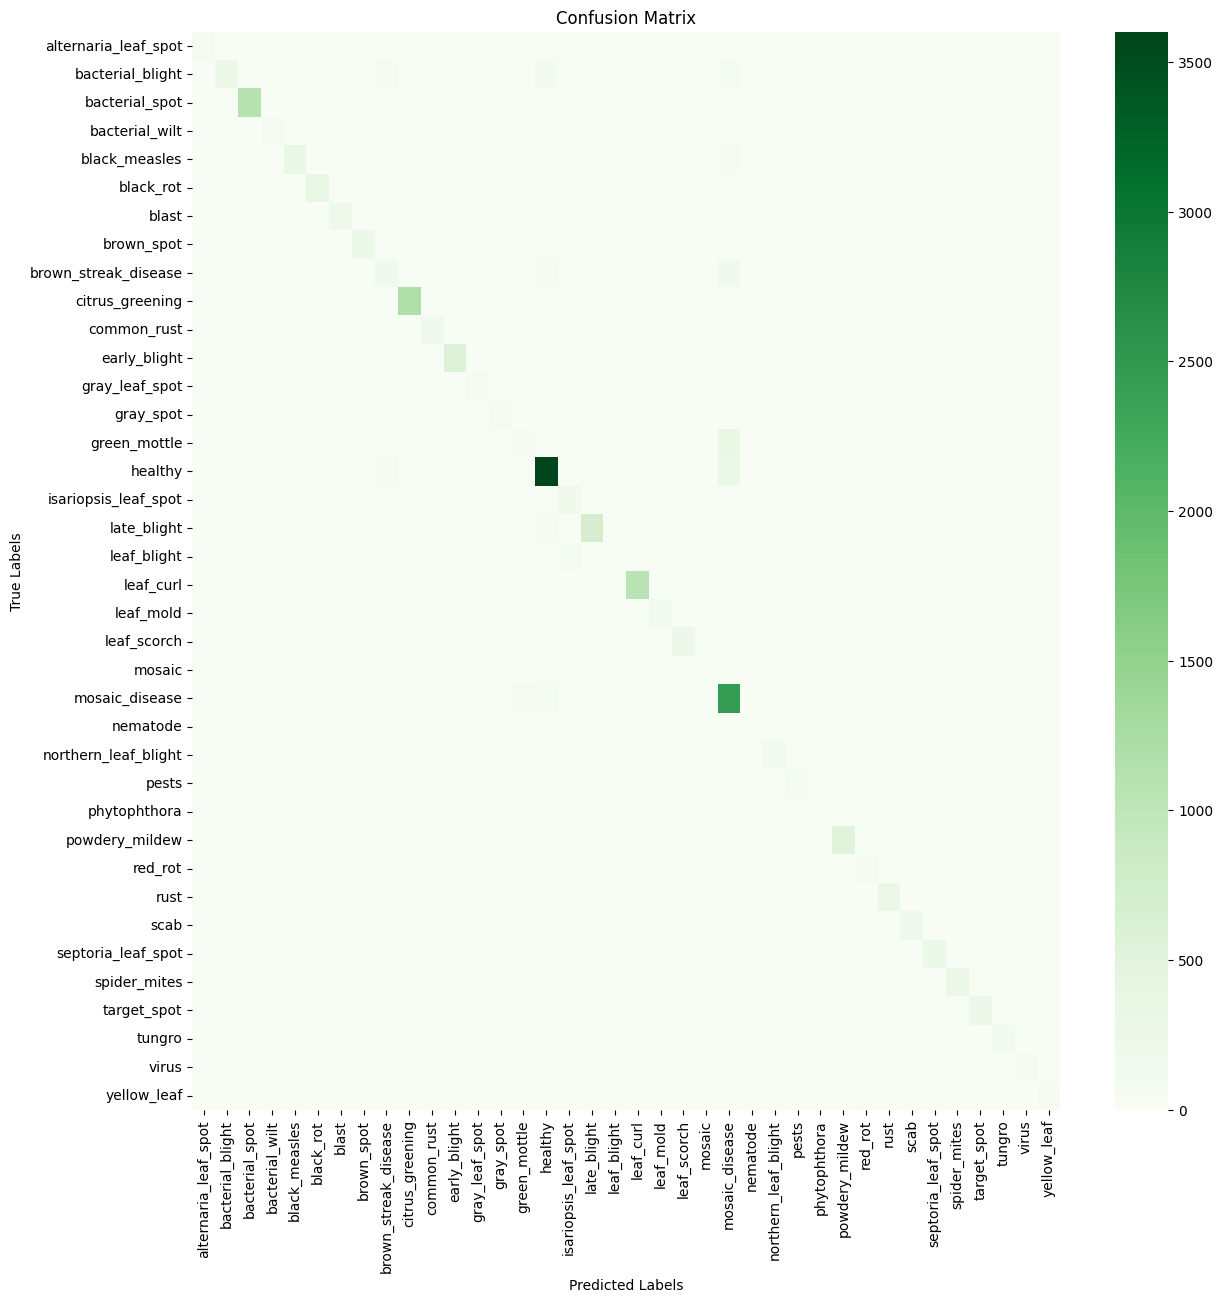

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()